SNR:  1.574442201002264
Mean Squared Error:  0.14406363388523616


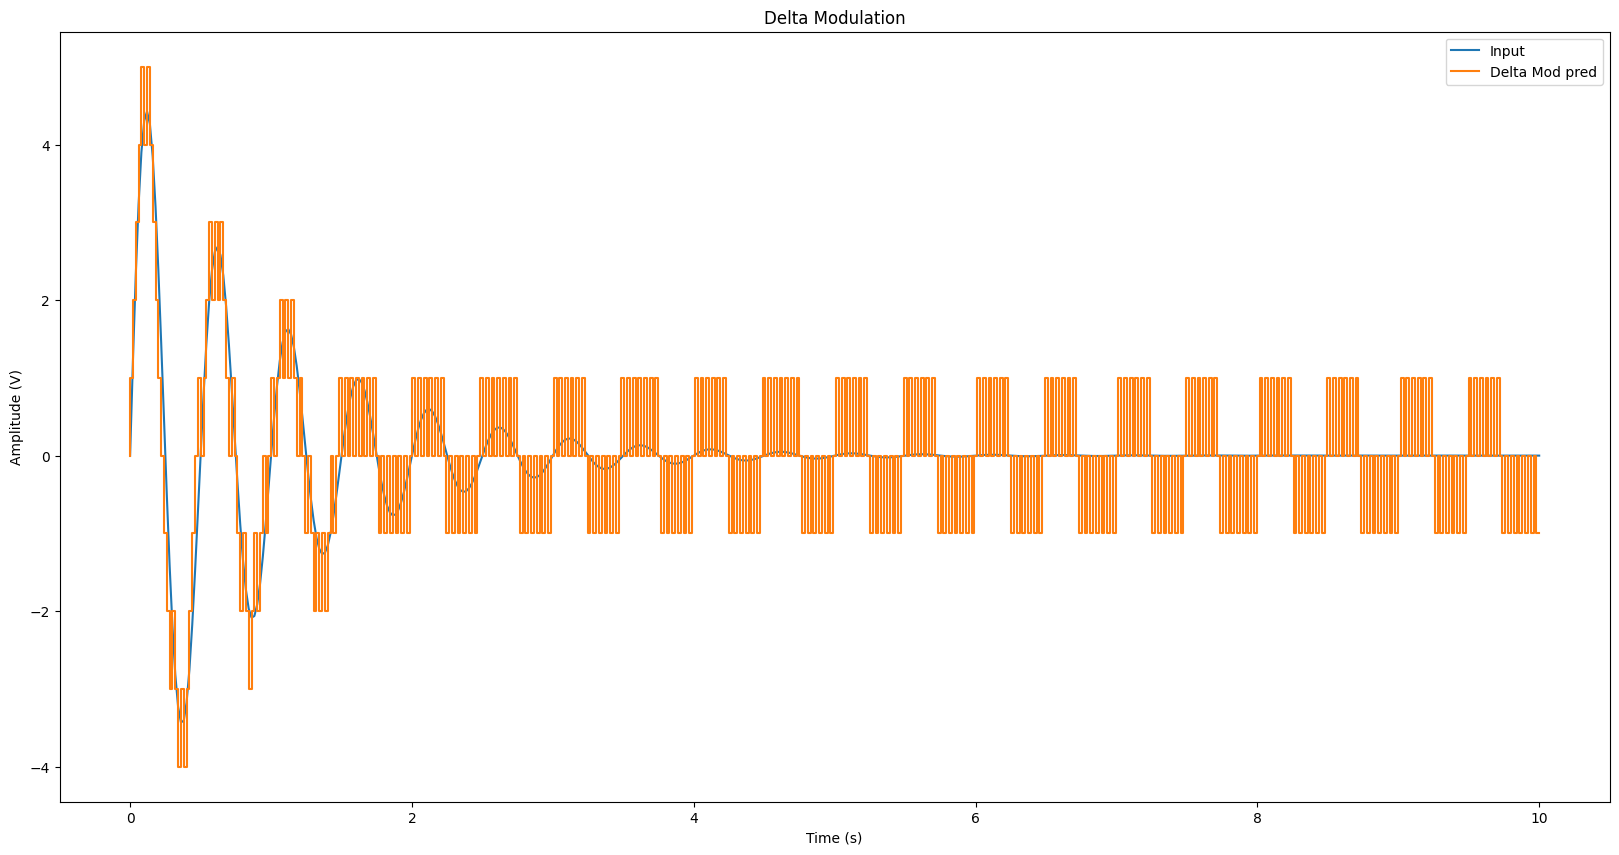

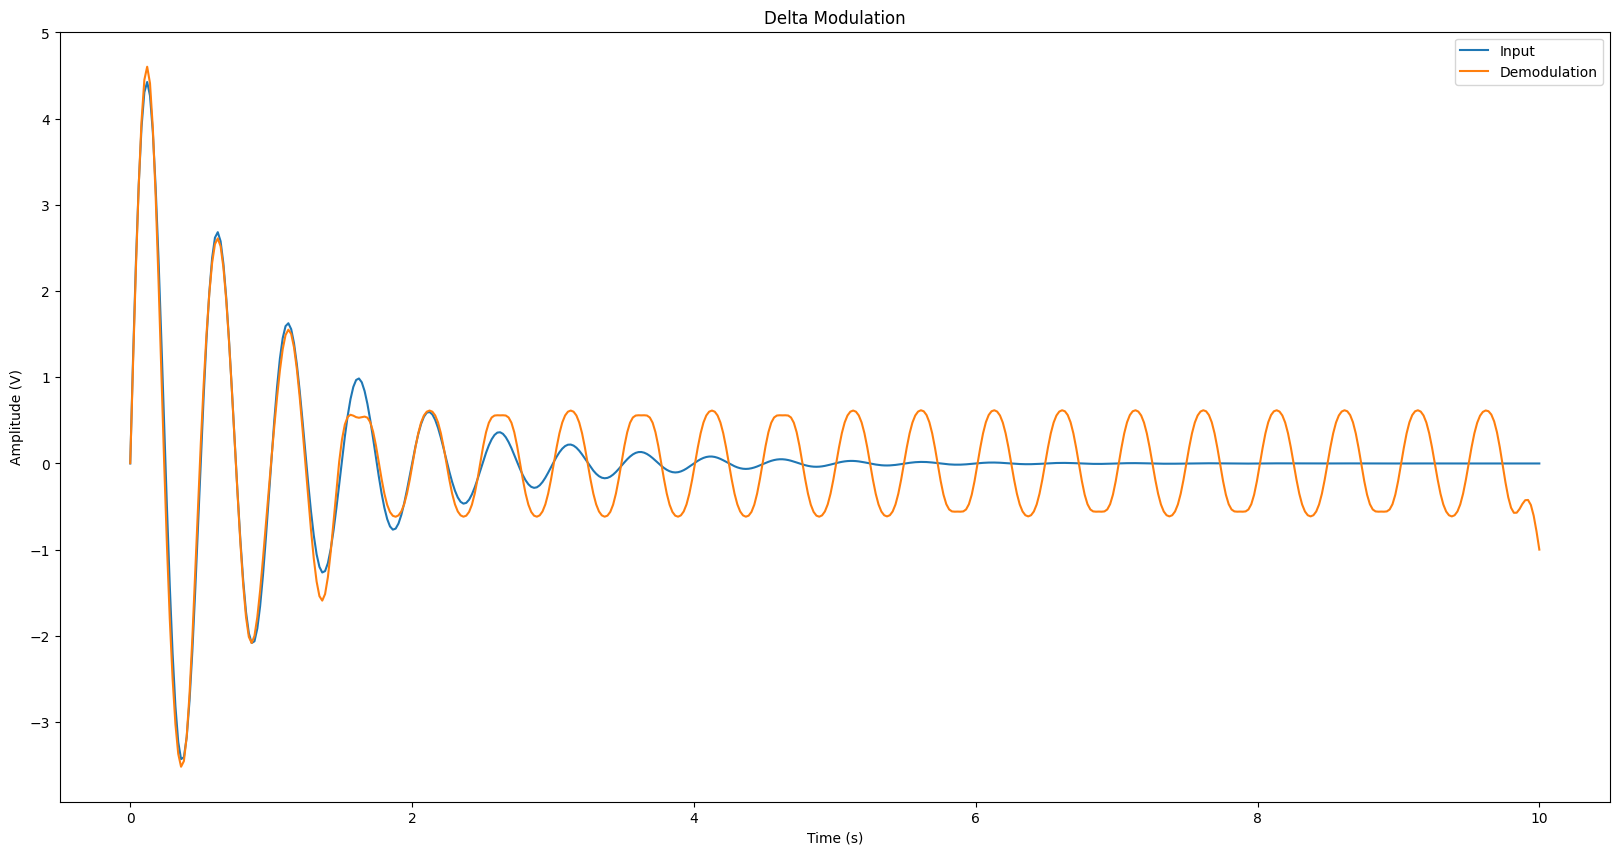

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
#Code for delta modulation using uniform step size

def delta_mod(data, delta): #function for delta modulation

    len_data = len(data)
    pred = np.zeros(len_data) #np.zeros makes array of zeros, pred is x_hat(n),i.e, output of prediction delay
    e_hat = np.zeros(len_data) # e_hat is data to be encoded, i.e, the quantized error eq(n) (output of the 1 bit quantizer)

    for i in range(1, len_data):
        # finding error e(n)= x(n) - x_hat_(n)
        e_n = data[i] - pred[i-1]
        # Quantization of error e(n)
        if (e_n >= 0):
            e_hat[i] = delta
        else:
            e_hat[i] = -delta
        # Accumulator
        pred[i] = pred[i-1] + e_hat[i] #pred[i] is the input to prediction delay

    # here we are encoding eq(n), if eq(n) is +ve, it is encoded to 1, else if -ve, its encoded to 0
    encoded = e_hat >= 0

    return encoded, pred

def delta_mod_demod(mod_data, delta, f, fs):
    #function for delta demodulation

    len_data = len(mod_data)
    x_dem = np.zeros(len_data) #initializing 0 array for demodulated signal

    for i in range(1, len_data):
        # we are converting encoded data we produced from modulator back to eq(n)
        if mod_data[i] == 0:
            e_hat = -delta
        else:
            e_hat = delta
        # we are constructing back the signal
        x_dem[i] = e_hat + x_dem[i-1]

    # Signal is in the form of staircase approximation. We reconstruct the original signal using a low pass filter
    fs = 1000 # Sampling rate (Hz)
    fc = 100 # Cutoff frequency (Hz)
    order = 4 # Filter order

    # Calculate filter coefficients using a Butterworth filter
    b, a = butter(order, fc / (fs / 2), 'low')

   # filtfilt: a linear filter that achieves zero phase delay by applying an IIR filter to a signal twice, once forwards and once backwards.
    demod = filtfilt(b, a, x_dem)

    return demod

def isnr(x, y):
    # Calculate Signal-to-Noise Ratio (SNR) in dB
    noise = x - y
    mse = np.mean(np.square(noise))
    return 10 * np.log10(np.mean(np.square(x))/mse) # Power formula for SNR

# Sin*Exp input, we r creating signal (exponential decaying sinusoid)
len_data = 500
t = np.linspace(0, 10, len_data) # NumPy function that returns an array of evenly spaced numbers over a specified interval.
Fs = 50
amp = 5
f = 2
x1 = amp * np.sin(2 * np.pi * f * t) * np.exp(-t)

# Delta Modulation
delta = 1 #initial step_size
dm_out, dm_pred = delta_mod(x1, delta)

# Demodulation
dm_demod = delta_mod_demod(dm_out, delta, f, Fs)

# MSE
dm_pred_snr1 = isnr(x1, dm_pred)
dm_demod_mse1 = np.mean(np.square(x1 - dm_demod))# Finding the mean squared error between input signal and output demodulated signal
print("SNR: ",dm_pred_snr1)
print("Mean Squared Error: ",dm_demod_mse1)

# Plotting
fig1 = plt.figure(figsize=(20, 10))
plt.plot(t, x1, label='Input')
plt.step(t, dm_pred, label='Delta Mod pred')
plt.title('Delta Modulation')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.legend()

fig2 = plt.figure(figsize=(20, 10))
plt.plot(t, x1, label='Input')
plt.plot(t, dm_demod, label='Demodulation')
plt.title('Delta Modulation')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.legend()

plt.show()